In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import RandomErasing
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA A100-SXM4-40GB


# Preparing Data

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# proportion of validation set to training set
valid_size = 0.2  # DO NOT MODIFY !!!

# convert data to torch.FloatTensor
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    # transforms.RandomRotation(10),      # 随机旋转10度
    # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),  # 随机缩放和裁剪
    # transforms.RandomGrayscale(p=0.3),  # 随机灰度变换
    transforms.ToTensor(),              # 转换为张量
    transforms.Normalize((0.1,), (0.1,)),  # 标准化
    # RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0)  # Random Erasing
])

valid_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1,), (0.1,))
])


# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=train_tfms)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=valid_tfms)

# split the training dataset into training set and validation set
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:],indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers) 

# FashionMNIST Dataset

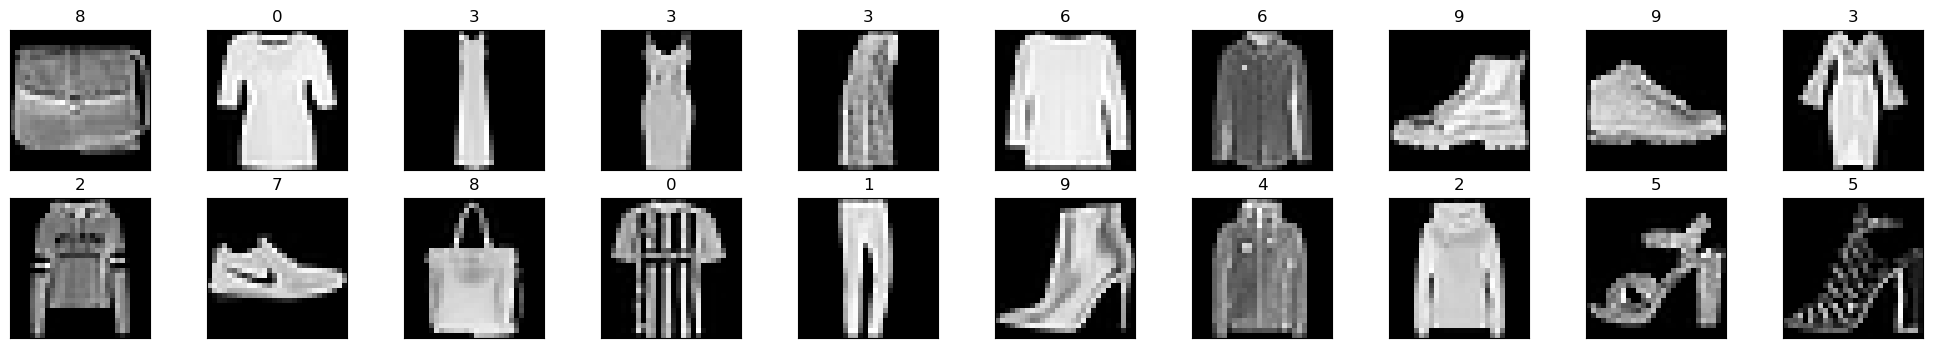

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

# Model Architecture

In [4]:
## define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # linear layers
        self.fc1 = nn.Linear(28 * 28, 512) # DO NOT MODIFY !!!
        self.fc2 = nn.Linear(512, 256)    # DO NOT MODIFY !!!
        self.fc3 = nn.Linear(256, 10)    # DO NOT MODIFY !!!
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)      # DO NOT MODIFY !!!
        x = self.fc1(x)           # DO NOT MODIFY !!!
        # add hidden layer, with relu activation function
        x = self.dropout(F.relu(x))
        x = self.fc2(x)           # DO NOT MODIFY !!!
        x = self.dropout(F.relu(x))
        x = self.fc3(x)           # DO NOT MODIFY !!!
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


# Hyperparameters

In [5]:
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# specify loss function
criterion = nn.CrossEntropyLoss()

# number of epochs to train the model
n_epochs = 10  # DO NOT MODIFY !!!

# specify optimizer

# 使用 AdamW 优化器
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

# 使用 ReduceLROnPlateau 学习率调度器
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# 如果你有需要，也可以选择使用 Adam 优化器和不同的 weight_decay 参数



# Training and Validation

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Move model to GPU
model.to(device)
print(device)

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
# Initialize history for recording what we want to know
history = []

for epoch in range(n_epochs):
    # Monitor training loss, validation loss, and learning rate
    train_loss = 0.0
    valid_loss = 0.0
    lrs = []
    result = {'train_loss': [], 'val_loss': [], 'lrs': []}

    # Prepare model for training
    model.train()

    #######################
    # Train the model #
    #######################
    for data, target in train_loader:
        # Move data and target to GPU
        data, target = data.to(device), target.to(device)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Record learning rate
        lrs.append(optimizer.param_groups[0]['lr'])

        # Update running training loss
        train_loss += loss.item() * data.size(0)

    ######################
    # Validate the model #
    ######################
    model.eval()
    with torch.no_grad():  # Turn off gradients for validation to save memory and computations
        for data, target in valid_loader:
            # Move data and target to GPU
            data, target = data.to(device), target.to(device)

            # Compute predicted outputs by passing inputs to the model
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            # Update running validation loss
            valid_loss += loss.item() * data.size(0)

    # Calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.dataset)
    result['train_loss'] = train_loss
    valid_loss = valid_loss / len(valid_sampler)
    result['val_loss'] = valid_loss
    result['lrs'] = lrs
    history.append(result)

    # Update learning rate using scheduler
    scheduler.step()

    print('Epoch {:2d}: Learning Rate: {:.6f} Training Loss: {:.6f} Validation Loss: {:.6f}'.format(
        epoch + 1,
        lrs[-1],
        train_loss,
        valid_loss
    ))

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...".format(
            valid_loss_min,
            valid_loss
        ))
        torch.save(model.state_dict(), "model.pt")
        valid_loss_min = valid_loss


cuda
Epoch  1: Learning Rate: 0.000035 Training Loss: 0.185416 Validation Loss: 0.279010
Validation loss decreased (inf --> 0.279010). Saving model ...
Epoch  2: Learning Rate: 0.000031 Training Loss: 0.179934 Validation Loss: 0.276290
Validation loss decreased (0.279010 --> 0.276290). Saving model ...
Epoch  3: Learning Rate: 0.000028 Training Loss: 0.174864 Validation Loss: 0.276129
Validation loss decreased (0.276290 --> 0.276129). Saving model ...
Epoch  4: Learning Rate: 0.000025 Training Loss: 0.169584 Validation Loss: 0.277464
Epoch  5: Learning Rate: 0.000023 Training Loss: 0.164103 Validation Loss: 0.276138
Epoch  6: Learning Rate: 0.000021 Training Loss: 0.161465 Validation Loss: 0.269944
Validation loss decreased (0.276129 --> 0.269944). Saving model ...
Epoch  7: Learning Rate: 0.000019 Training Loss: 0.159372 Validation Loss: 0.270788
Epoch  8: Learning Rate: 0.000017 Training Loss: 0.155375 Validation Loss: 0.270813
Epoch  9: Learning Rate: 0.000015 Training Loss: 0.15145

# Plot Learning Rate Curve

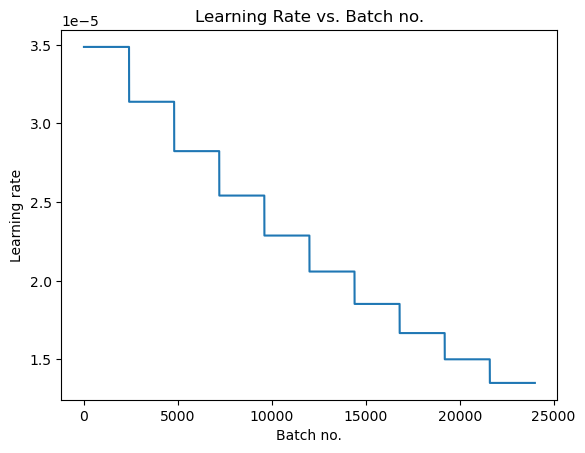

In [11]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

plot_lrs(history)

# Plot Loss Curve

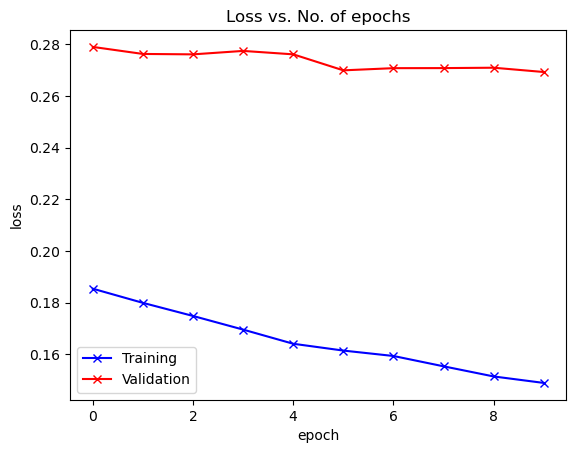

In [12]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

plot_losses(history)

# Testing

In [13]:

import torch

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# 将模型移动到GPU
model.to(device)

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# prep model for evaluation
model.eval()

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of Class %5s: %2.2f%% (%2d/%2d)' % (
            str(i),
            100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]),
            np.sum(class_total[i])
            ))
    else:
        print('Test Accuracy of Class %5s: N/A (no training examples)' % (str[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100 * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct),
    np.sum(class_total)
    ))

Test Loss: 0.306247

Test Accuracy of Class     0: 85.30% (853/1000)
Test Accuracy of Class     1: 98.30% (983/1000)
Test Accuracy of Class     2: 84.00% (840/1000)
Test Accuracy of Class     3: 89.40% (894/1000)
Test Accuracy of Class     4: 81.90% (819/1000)
Test Accuracy of Class     5: 95.20% (952/1000)
Test Accuracy of Class     6: 70.80% (708/1000)
Test Accuracy of Class     7: 96.70% (967/1000)
Test Accuracy of Class     8: 97.30% (973/1000)
Test Accuracy of Class     9: 95.20% (952/1000)

Test Accuracy (Overall): 89.41% (8941/10000)
